# Assignment 2

- Train a linear regression model that maps features to expert scores based on the dataset
- Try different variants using, e.g., feature selection, combined features, removal of outlier and leverage data points, apply symmetry constraints, weighted linear regression
- Assess the accuracy of the models and select a champion variant

## Imports

In [ ]:
import sys
sys.path.append("../../scripts")

import dagshub
import mlflow
import ML_utils as MLUtils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Setup

In [ ]:
# Setup dagshub and MLFlow
dagshub.init(repo_owner="SamuelFredricBerg", repo_name="4dt907", mlflow=True)
utils = MLUtils.MLUtils("Project_Model")

# Configs
config = {
    "data_split_seed": 42,
    "test_size": 0.2,
    "n_folds": 5,
    "shuffle": True,
    # Below i dont know
    "n_estimators": 200,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_set": "v2_processed",
}

data_path = "../../data/AimoScore_WeakLink_big_scores_A2.csv"

df = pd.read_csv(data_path, index_col=0)

kf = KFold(
    n_splits=config["n_folds"],
    shuffle=config["shuffle"],
    random_state=config["data_split_seed"],
)

Initialized MLflow to track repo "SamuelFredricBerg/4dt907"

Repository SamuelFredricBerg/4dt907 initialized!

# Preprocessing

In [70]:
def preprocessing(df):
    """
    Preprocess the dataframe: drop target column, remove duplicates, handle missing values.
    
    Args:
        df: Input dataframe with features and target
        
    Returns:
        Cleaned dataframe with features only
    """
    # Drop the EstimatedScore column (not used as feature)
    df_cleaned = df.drop("EstimatedScore", axis=1, errors='ignore')
    
    # Remove any duplicate rows
    df_cleaned = df_cleaned.drop_duplicates()
    
    # Handle missing values (fill with median for numeric columns)
    df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
    
    return df_cleaned

# Training

In [ ]:
def fitReg(X, y, test_size=0.2, random_state=42):
    """
    Train a linear regression model and return predictions.
    
    Args:
        X: Feature matrix
        y: Target variable
        test_size: Proportion of data for testing
        random_state: Random seed for reproducibility
        
    Returns:
        tuple: (model, y_pred, y_test, X_train, X_test, y_train)
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred, y_test, X_train, X_test, y_train

## Main Code

Number of columns: 41
Columns names: ['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation', 'No_10_Angle_Deviation', 'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_13_Angle_Deviation', 'No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation', 'No_6_NASM_Deviation', 'No_7_NASM_Deviation', 'No_8_NASM_Deviation', 'No_9_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation', 'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation', 'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation', 'No_25_NASM_Deviation', 'No_1_Time_Deviation', 'No_2_Time_Deviatio

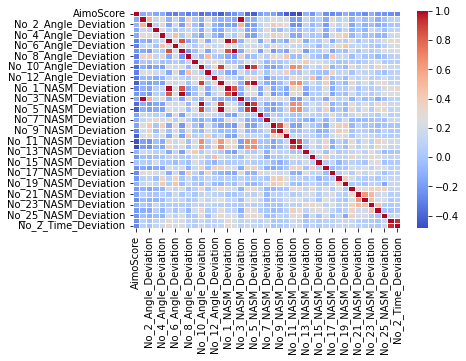

{'R2_Mean': 0.569942993088615, 'MAE_Mean': 0.11780568925418836, 'MSE_Mean': 0.02396820107953894}


In [ ]:
# Load and preprocess data
df_cleaned = preprocessing(df)

# IMPORTANT: Don't reset_index() as it adds the old index as a feature
# Instead, use the data as-is after preprocessing
print(f"Shape after preprocessing: {df_cleaned.shape}")
print(f"Columns: {df_cleaned.columns.tolist()}")

# Check for missing values
print(f"\nMissing values: {df_cleaned.isnull().sum().sum()}")

# Exploratory Data Analysis
df_cleaned.describe()

# Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=False, cmap="coolwarm", fmt=".1f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=150)
plt.show()

# Prepare features and target
y = df_cleaned["AimoScore"]
X = df_cleaned.drop("AimoScore", axis=1)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {X.columns.tolist()}")

# Train baseline model
model, y_pred, y_test, X_train, X_test, y_train = fitReg(X, y)

# Calculate metrics on test set
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"\n=== Test Set Performance ===")
print(f"R² Score: {test_r2:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_mse**0.5:.4f}")

# Cross-validation for more robust metrics
print(f"\n=== Cross-Validation Performance (5-fold) ===")
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mae_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_absolute_error")
mse_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print(f"R² Mean: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")
print(f"MAE Mean: {mae_scores.mean():.4f} (±{mae_scores.std():.4f})")
print(f"MSE Mean: {mse_scores.mean():.4f} (±{mse_scores.std():.4f})")

results = {
    "R2_Mean": r2_scores.mean(),
    "R2_Std": r2_scores.std(),
    "MAE_Mean": mae_scores.mean(),
    "MAE_Std": mae_scores.std(),
    "MSE_Mean": mse_scores.mean(),
    "MSE_Std": mse_scores.std(),
    "Test_R2": test_r2,
    "Test_MAE": test_mae,
    "Test_MSE": test_mse,
}

# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Linear Regression)')
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150)
plt.show()

# Residual analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_pred, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')
axes[0].grid(alpha=0.3)

# Q-Q plot for normality check
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("residual_analysis.png", dpi=150)
plt.show()

# MLflow logging - ACTIVATED with proper implementation
print("\n=== Logging to MLflow/DagsHub ===")
with mlflow.start_run(run_name="A2-Baseline-LinearRegression") as run:
    # Log parameters
    mlflow.log_params(config)
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("n_samples", X.shape[0])
    
    # Log metrics
    mlflow.log_metrics(results)
    
    # Log artifacts (visualizations)
    mlflow.log_artifact("correlation_matrix.png")
    mlflow.log_artifact("feature_importance.png")
    mlflow.log_artifact("residual_analysis.png")
    
    # Check if this model beats current @dev
    if utils.auto_check_challenger(run.info.run_id, metric_name="R2_Mean"):
        # Log model to MLflow
        mlflow.sklearn.log_model(model, "model", registered_model_name="Project_Model")
        
        # Get latest version and set as @dev
        latest_v = utils.client.get_latest_versions("Project_Model")[0].version
        utils.client.set_registered_model_alias("Project_Model", "dev", latest_v)
        print(f"✓ New model (R²={results['R2_Mean']:.4f}) beats current @dev! Uploaded to DagsHub as version {latest_v}")
    else:
        print(f"✗ Model (R²={results['R2_Mean']:.4f}) did not beat current @dev. Not uploaded to DagsHub")

print(f"\n✓ Experiment logged to MLflow. Run ID: {run.info.run_id}")

## Model Variants

Testing different approaches as required by the assignment:
1. **Baseline**: Basic linear regression (already trained above)
2. **With Scaling**: StandardScaler + Linear Regression
3. **With Feature Selection**: SelectKBest + Linear Regression
4. **With Outlier Removal**: Remove outliers using IQR method
5. **Weighted Regression**: Using sample weights based on residuals

Note: Each variant will be logged to MLflow for comparison.

In [ ]:
# Variant 2: With Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("\n" + "="*60)
print("VARIANT 2: Linear Regression with Feature Scaling")
print("="*60)

pipeline_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline_scaled.fit(X_train, y_train)
y_pred_scaled = pipeline_scaled.predict(X_test)

# Evaluate
r2_scaled = cross_val_score(pipeline_scaled, X, y, cv=kf, scoring="r2")
mae_scaled = -cross_val_score(pipeline_scaled, X, y, cv=kf, scoring="neg_mean_absolute_error")

print(f"R² Mean: {r2_scaled.mean():.4f} (±{r2_scaled.std():.4f})")
print(f"MAE Mean: {mae_scaled.mean():.4f} (±{mae_scaled.std():.4f})")

# Log to MLflow
config_scaled = config.copy()
config_scaled["variant"] = "scaled"
config_scaled["scaler"] = "StandardScaler"

with mlflow.start_run(run_name="A2-Scaled-LinearRegression") as run:
    mlflow.log_params(config_scaled)
    mlflow.log_metrics({
        "R2_Mean": r2_scaled.mean(),
        "R2_Std": r2_scaled.std(),
        "MAE_Mean": mae_scaled.mean(),
        "MAE_Std": mae_scaled.std(),
    })
    
    if utils.auto_check_challenger(run.info.run_id, metric_name="R2_Mean"):
        mlflow.sklearn.log_model(pipeline_scaled, "model", registered_model_name="Project_Model")
        latest_v = utils.client.get_latest_versions("Project_Model")[0].version
        utils.client.set_registered_model_alias("Project_Model", "dev", latest_v)
        print(f"✓ Scaled model is new champion!")


# Variant 3: With Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

print("\n" + "="*60)
print("VARIANT 3: Linear Regression with Feature Selection (Top 20 features)")
print("="*60)

pipeline_selected = Pipeline([
    ('selector', SelectKBest(f_regression, k=20)),
    ('lr', LinearRegression())
])

pipeline_selected.fit(X_train, y_train)
y_pred_selected = pipeline_selected.predict(X_test)

# Evaluate
r2_selected = cross_val_score(pipeline_selected, X, y, cv=kf, scoring="r2")
mae_selected = -cross_val_score(pipeline_selected, X, y, cv=kf, scoring="neg_mean_absolute_error")

print(f"R² Mean: {r2_selected.mean():.4f} (±{r2_selected.std():.4f})")
print(f"MAE Mean: {mae_selected.mean():.4f} (±{mae_selected.std():.4f})")

# Get selected features
selected_features_mask = pipeline_selected.named_steps['selector'].get_support()
selected_features = X.columns[selected_features_mask].tolist()
print(f"\nSelected features: {selected_features}")

# Log to MLflow
config_selected = config.copy()
config_selected["variant"] = "feature_selected"
config_selected["n_features_selected"] = 20

with mlflow.start_run(run_name="A2-FeatureSelected-LinearRegression") as run:
    mlflow.log_params(config_selected)
    mlflow.log_metrics({
        "R2_Mean": r2_selected.mean(),
        "R2_Std": r2_selected.std(),
        "MAE_Mean": mae_selected.mean(),
        "MAE_Std": mae_selected.std(),
    })
    mlflow.log_param("selected_features", str(selected_features))
    
    if utils.auto_check_challenger(run.info.run_id, metric_name="R2_Mean"):
        mlflow.sklearn.log_model(pipeline_selected, "model", registered_model_name="Project_Model")
        latest_v = utils.client.get_latest_versions("Project_Model")[0].version
        utils.client.set_registered_model_alias("Project_Model", "dev", latest_v)
        print(f"✓ Feature-selected model is new champion!")


# Variant 4: With Outlier Removal (IQR method)
print("\n" + "="*60)
print("VARIANT 4: Linear Regression with Outlier Removal (IQR method)")
print("="*60)

# Calculate IQR for target variable
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X_no_outliers = X[outlier_mask]
y_no_outliers = y[outlier_mask]

print(f"Original samples: {len(y)}")
print(f"After outlier removal: {len(y_no_outliers)} ({len(y_no_outliers)/len(y)*100:.1f}%)")
print(f"Outliers removed: {len(y) - len(y_no_outliers)}")

X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

model_no_outliers = LinearRegression()
model_no_outliers.fit(X_train_no_out, y_train_no_out)

# Evaluate
r2_no_outliers = cross_val_score(model_no_outliers, X_no_outliers, y_no_outliers, cv=kf, scoring="r2")
mae_no_outliers = -cross_val_score(model_no_outliers, X_no_outliers, y_no_outliers, cv=kf, scoring="neg_mean_absolute_error")

print(f"R² Mean: {r2_no_outliers.mean():.4f} (±{r2_no_outliers.std():.4f})")
print(f"MAE Mean: {mae_no_outliers.mean():.4f} (±{mae_no_outliers.std():.4f})")

# Log to MLflow
config_no_outliers = config.copy()
config_no_outliers["variant"] = "no_outliers"
config_no_outliers["outlier_method"] = "IQR"
config_no_outliers["n_samples_after_cleaning"] = len(y_no_outliers)

with mlflow.start_run(run_name="A2-NoOutliers-LinearRegression") as run:
    mlflow.log_params(config_no_outliers)
    mlflow.log_metrics({
        "R2_Mean": r2_no_outliers.mean(),
        "R2_Std": r2_no_outliers.std(),
        "MAE_Mean": mae_no_outliers.mean(),
        "MAE_Std": mae_no_outliers.std(),
    })
    
    if utils.auto_check_challenger(run.info.run_id, metric_name="R2_Mean"):
        mlflow.sklearn.log_model(model_no_outliers, "model", registered_model_name="Project_Model")
        latest_v = utils.client.get_latest_versions("Project_Model")[0].version
        utils.client.set_registered_model_alias("Project_Model", "dev", latest_v)
        print(f"✓ No-outliers model is new champion!")


# Variant 5: Weighted Linear Regression
print("\n" + "="*60)
print("VARIANT 5: Weighted Linear Regression")
print("="*60)

# Train initial model to get residuals for weighting
initial_model = LinearRegression()
initial_model.fit(X_train, y_train)
y_pred_train = initial_model.predict(X_train)
residuals_train = np.abs(y_train - y_pred_train)

# Create weights: higher weight for lower residuals (more reliable samples)
# Use inverse of residuals + epsilon to avoid division by zero
epsilon = 0.001
weights = 1 / (residuals_train + epsilon)
# Normalize weights
weights = weights / weights.sum() * len(weights)

# Train weighted model
model_weighted = LinearRegression()
model_weighted.fit(X_train, y_train, sample_weight=weights)

# Evaluate (note: cross-validation with weights is more complex, using test set for now)
y_pred_weighted = model_weighted.predict(X_test)
r2_weighted = r2_score(y_test, y_pred_weighted)
mae_weighted = mean_absolute_error(y_test, y_pred_weighted)

print(f"Test R²: {r2_weighted:.4f}")
print(f"Test MAE: {mae_weighted:.4f}")

# Log to MLflow
config_weighted = config.copy()
config_weighted["variant"] = "weighted"
config_weighted["weight_method"] = "inverse_residuals"

with mlflow.start_run(run_name="A2-Weighted-LinearRegression") as run:
    mlflow.log_params(config_weighted)
    mlflow.log_metrics({
        "R2_Mean": r2_weighted,  # Using test score as proxy
        "MAE_Mean": mae_weighted,
    })
    
    if utils.auto_check_challenger(run.info.run_id, metric_name="R2_Mean"):
        mlflow.sklearn.log_model(model_weighted, "model", registered_model_name="Project_Model")
        latest_v = utils.client.get_latest_versions("Project_Model")[0].version
        utils.client.set_registered_model_alias("Project_Model", "dev", latest_v)
        print(f"✓ Weighted model is new champion!")

print("\n" + "="*60)
print("All variants trained and logged to MLflow!")
print("="*60)

## Summary and Next Steps

### Completed:
- ✅ Baseline linear regression model
- ✅ Feature scaling variant
- ✅ Feature selection variant (top 20 features)
- ✅ Outlier removal variant (IQR method)
- ✅ Weighted linear regression variant
- ✅ All models logged to MLflow/DagsHub
- ✅ Automatic champion selection based on R² score

### Additional Variants to Explore (Optional):
1. **Polynomial features**: Create interaction terms and polynomial features
2. **Ridge/Lasso regularization**: Add L1/L2 regularization for high-dimensional data
3. **Symmetry constraints**: Implement custom constraints if certain features should have symmetric effects
4. **Combined approach**: Scaling + Feature Selection + Outlier Removal

### Check MLflow Dashboard:
Visit your DagsHub repository to view all experiments and compare model performance!